# Tutorial 6 SpatialEx+ is Robust Even When There is Weak or No Overlap between Slices

## 6.1 Quantitative Analysis

In [1]:
import warnings

import numpy as np
import scanpy as sc
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import preprocess as pp
from utils import Compute_metrics

Panel A on Slice2

In [6]:
selection = pd.read_csv('./datasets/Selection_by_name.csv', index_col=0)
panelA = selection.index[selection['slice1']].tolist()
panelB = selection.index[selection['slice2']].tolist()

ref2 = sc.read_h5ad('./datasets/Human_Breast_Cancer_Rep2/Human_Breast_Cancer_Rep2_uni_resolution64_genes2.h5ad')
h5_path2 = './datasets/Human_Breast_Cancer_Rep2/cell_feature_matrix.h5'
obs_path2 = './datasets/Human_Breast_Cancer_Rep2/cells.csv'
adata2 = pp.Read_Xenium(h5_path2, obs_path2)
adata2 = pp.Preprocess_adata(adata2, cell_mRNA_cutoff=0, selected_genes=panelA)
adata2 = adata2[ref2.obs_names]
adata2

/home/wcy/anaconda3/envs/torch2X/lib/python3.8/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [1, 2, 3, 4, 5]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
/home/wcy/anaconda3/envs/torch2X/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_counts'] = number
/home/wcy/anaconda3/envs/torch2X/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


View of AnnData object with n_obs × n_vars = 110947 × 150
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'log1p'
    obsm: 'spatial'
    layers: 'raw'

In [18]:
stride_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
pcc_list_A2 = []
pcc_mean_list_A2 = []
pcc_std_list_A2 = []

for stride in tqdm(stride_list):    
    A2 = pd.read_csv('./output/ABLATION/Sliding_windows/A2_Stride_'+str(stride)+'_x_fixed_windows.csv', index_col=0)
    obs = A2.index.astype(str)
    A2 = np.maximum(A2.values, 0)
    pcc, pcc_reduce = Compute_metrics(A2.copy(), adata2[obs].X.copy(), metric='pcc', reduce='mean')
    pcc_mean_list_A2.append(pcc_reduce)
    pcc_std_list_A2.append(pcc.std())
    pcc_list_A2.append(list(pcc))

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.48s/it]


In [19]:
stride_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
pcc_list_A2_inner = []
pcc_mean_list_A2_inner = []
pcc_std_list_A2_inner = []

for stride in tqdm(stride_list):    
    A2 = pd.read_csv('./output/ABLATION/Sliding_windows/A2_Stride_'+str(stride)+'_x_fixed_windows_new.csv', index_col=0)
    obs = A2.index.astype(str)
    A2 = np.maximum(A2.values, 0)
    pcc, pcc_reduce = Compute_metrics(A2.copy(), adata2[obs].X.copy(), metric='pcc', reduce='mean')
    pcc_mean_list_A2_inner.append(pcc_reduce)
    pcc_std_list_A2_inner.append(pcc.std())
    pcc_list_A2_inner.append(list(pcc))

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.47it/s]


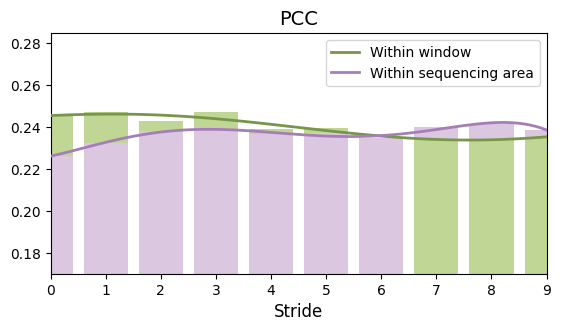

In [21]:
coefficients = np.polyfit(np.arange(10), pcc_mean_list_A2, deg=5)
coefficients1 = np.polyfit(np.arange(10), pcc_mean_list_A2_inner, deg=5)
y_fit = np.polyval(coefficients, np.linspace(0, 10, 100))
y_fit1 = np.polyval(coefficients1, np.linspace(0, 10, 100))

plt.plot(np.linspace(0, 10, 100), y_fit1, c='#779649', linewidth=2, label='Within window', zorder=3)
plt.bar(np.arange(10), pcc_mean_list_A2_inner, color='#C0D695', linewidth=2)

plt.plot(np.linspace(0, 10, 100), y_fit, c='#A67EB7', linewidth=2, label='Within sequencing area', zorder=3)
plt.bar(np.arange(10), pcc_mean_list_A2, color='#DCC7E1', linewidth=2)

selection = np.array(pcc_mean_list_A2_inner) < np.array(pcc_mean_list_A2)
plt.bar(np.arange(10)[selection], np.array(pcc_mean_list_A2_inner)[selection], color='#C0D695', linewidth=2, zorder=2)


plt.xlabel('Stride', fontsize=12)
plt.xlim(0, 9)
plt.ylim(0.17, 0.285)
ax = plt.gca()
ax.set_aspect(38)
plt.title('PCC', fontsize=14)
plt.xticks(np.arange(10), np.arange(10))
plt.legend()
plt.show()

## 6.2 Qualitative Analysis

### 6.2.1 Spatial gene distribution (*CD3E* and *CTTN*)

In [24]:
ref1 = sc.read_h5ad('./datasets/Human_Breast_Cancer_Rep1/Human_Breast_Cancer_Rep1_uni_resolution64_genes1.h5ad')
ref2 = sc.read_h5ad('./datasets/Human_Breast_Cancer_Rep2/Human_Breast_Cancer_Rep2_uni_resolution64_genes2.h5ad')
spatial1 = ref1.obsm['image_coor']
spatial2 = ref2.obsm['image_coor']

coor_out1 = pd.read_csv('./datasets/Human_Breast_Cancer_Rep1/HBRC_Rep1_cell_coor.csv', index_col=0).values
coor_out2 = pd.read_csv('./datasets/Human_Breast_Cancer_Rep2/HBRC_Rep2_cell_coor.csv', index_col=0).values

h5_path1 = './datasets/Human_Breast_Cancer_Rep1/cell_feature_matrix.h5'
obs_path1 = './datasets/Human_Breast_Cancer_Rep1/cells.csv'
adata1 = pp.Read_Xenium(h5_path1, obs_path1)
adata1 = pp.Preprocess_adata(adata1, cell_mRNA_cutoff=0, selected_genes=panelB)  # 不筛除细胞， 构建slice1上的panelB的ground truth
adata1 = adata1[ref1.obs_names]

h5_path2 = './datasets/Human_Breast_Cancer_Rep2/cell_feature_matrix.h5'
obs_path2 = './datasets/Human_Breast_Cancer_Rep2/cells.csv'
adata2 = pp.Read_Xenium(h5_path2, obs_path2)
adata2 = pp.Preprocess_adata(adata2, cell_mRNA_cutoff=0, selected_genes=panelA)  # 不筛除细胞， 构建slice1上的panelB的ground truth
adata2 = adata2[ref2.obs_names]
adata1, adata2

/home/wcy/anaconda3/envs/torch2X/lib/python3.8/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [1, 2, 3, 4, 5]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
/home/wcy/anaconda3/envs/torch2X/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_counts'] = number
/home/wcy/anaconda3/envs/torch2X/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))
/home/wcy/anaconda3/envs/torch2X/lib/python3.8/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [1, 2, 3, 4, 5]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
/home/wcy/anacond

(View of AnnData object with n_obs × n_vars = 161542 × 163
     obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_counts'
     var: 'gene_ids', 'feature_types', 'genome'
     uns: 'log1p'
     obsm: 'spatial'
     layers: 'raw',
 View of AnnData object with n_obs × n_vars = 110947 × 150
     obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_counts'
     var: 'gene_ids', 'feature_types', 'genome'
     uns: 'log1p'
     obsm: 'spatial'
     layers: 'raw')

Visualization of the gene *CTTN* under the complete overlap setting

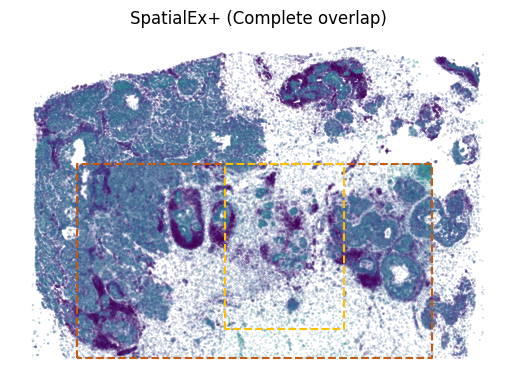

In [27]:
xstart1 = 4100
xstart2 = 4400
ystart1 = 3650
ystart2 = 1750 
x_stride = 155
x_radius = 1250
y_radius = 1750
i = 0
x, y = ref2.obsm['spatial'][:, 0], ref2.obsm['spatial'][:, 1]
xcenter2 = xstart2 - i*x_stride
xleft = xcenter2 - x_radius - 1
xright = xcenter2 + x_radius + 1
ycenter1 = ystart2
ytop = ycenter1 + y_radius + 1
ybottom = ycenter1 - y_radius - 1
selection = (x>xleft) & (x<xright) & (y<ytop) & (y>ybottom)
trainset2 = ref2[selection].obsm['image_coor']

step = 0
gene_name = 'CTTN'
gene_idx = np.where(np.array(panelA) == gene_name)

x, y = spatial2[:, 0], spatial2[:, 1]
vmax = adata2[:, gene_name].X.max()

A2_inner = pd.read_csv('./output/ABLATION/Sliding_windows/Out/panelA2_indirect_Stride_'+str(step)+'.csv', index_col=0)
A2_out_s9 = pd.read_csv('./output/ABLATION/Sliding_windows/Out/panelA2_out_indirect_Stride_'+str(step)+'.csv', index_col=0)
pcc, pcc_reduce = Compute_metrics(adata2.X.copy(), A2_inner.values, metric='pcc', reduce='mean')

plt.scatter(x, y, c=A2_inner[gene_name].values, vmax=vmax, s=0.008)

inner_x_min, inner_x_max = x.min(), x.max()
inner_y_min, inner_y_max = y.min(), y.max()
y, x = coor_out2[:, 0], coor_out2[:, 1]
selection = (x<inner_x_min+50) + (x>inner_x_max) + (y<inner_y_min) + (y>inner_y_max-100)
plt.scatter(x[selection], y[selection], c=A2_out_s9[gene_name][selection], vmax=vmax, s=0.012)
plt.plot([inner_x_min, inner_x_min, inner_x_max, inner_x_max, inner_x_min], [inner_y_min, inner_y_max, inner_y_max, inner_y_min, inner_y_min],
        c='#C55A11', linestyle='--')

train_x_min, train_x_max = trainset2[:, 0].min(), trainset2[:, 0].max()
train_y_min, train_y_max = trainset2[:, 1].min(), trainset2[:, 1].max()
plt.plot([train_x_min, train_x_min, train_x_max, train_x_max, train_x_min], [train_y_min, train_y_max, train_y_max, train_y_min, train_y_min], 
         c='#FFC000', linestyle='--')

ax = plt.gca()
ax.set_aspect(1)
plt.axis('off')
str_pcc = str(np.round(pcc[np.where(adata2.var_names==gene_name)[0]], 2)[0])
plt.title('SpatialEx+ (Complete overlap)', fontsize=12)
plt.show()

Visualization of the gene *CTTN* under the non-overlap setting

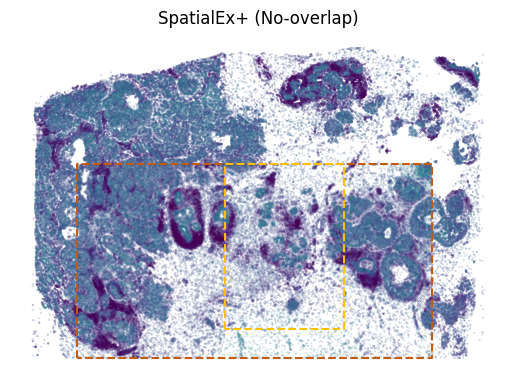

In [28]:
step = 9
gene_name = 'CTTN'
gene_idx = np.where(np.array(panelA) == gene_name)

x, y = spatial2[:, 0], spatial2[:, 1]
vmax = adata2[:, gene_name].X.max()

A2_inner = pd.read_csv('./output/ABLATION/Sliding_windows/Out/panelA2_indirect_Stride_'+str(step)+'.csv', index_col=0)
A2_out_s9 = pd.read_csv('./output/ABLATION/Sliding_windows/Out/panelA2_out_indirect_Stride_'+str(step)+'.csv', index_col=0)
pcc, pcc_reduce = Compute_metrics(adata2.X.copy(), A2_inner.values, metric='pcc', reduce='mean')

plt.scatter(x, y, c=A2_inner[gene_name].values, vmax=vmax, s=0.008)

inner_x_min, inner_x_max = x.min(), x.max()
inner_y_min, inner_y_max = y.min(), y.max()
y, x = coor_out2[:, 0], coor_out2[:, 1]
selection = (x<inner_x_min+50) + (x>inner_x_max) + (y<inner_y_min) + (y>inner_y_max-100)
plt.scatter(x[selection], y[selection], c=A2_out_s9[gene_name][selection], vmax=vmax, s=0.012)
plt.plot([inner_x_min, inner_x_min, inner_x_max, inner_x_max, inner_x_min], [inner_y_min, inner_y_max, inner_y_max, inner_y_min, inner_y_min],
        c='#C55A11', linestyle='--')

train_x_min, train_x_max = trainset2[:, 0].min(), trainset2[:, 0].max()
train_y_min, train_y_max = trainset2[:, 1].min(), trainset2[:, 1].max()
plt.plot([train_x_min, train_x_min, train_x_max, train_x_max, train_x_min], [train_y_min, train_y_max, train_y_max, train_y_min, train_y_min], 
         c='#FFC000', linestyle='--')

ax = plt.gca()
ax.set_aspect(1)
plt.axis('off')
str_pcc = str(np.round(pcc[np.where(adata2.var_names==gene_name)[0]], 2)[0])
plt.title('SpatialEx+ (No-overlap)', fontsize=12)
plt.show()

Visualization of the gene *CD3E* under the complete overlap setting

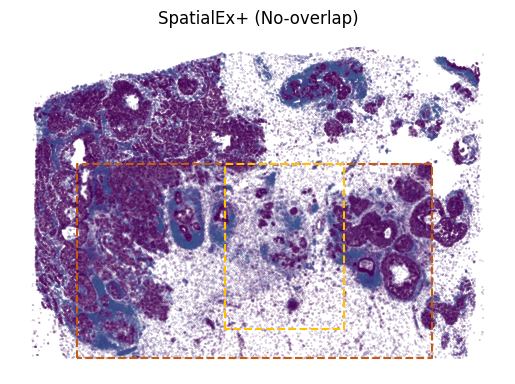

In [32]:
step = 0
gene_name = 'CD3E'
gene_idx = np.where(np.array(panelA) == gene_name)

x, y = spatial2[:, 0], spatial2[:, 1]
vmax = adata2[:, gene_name].X.max()

A2_inner = pd.read_csv('./output/ABLATION/Sliding_windows/Out/panelA2_indirect_Stride_'+str(step)+'.csv', index_col=0)
A2_out_s9 = pd.read_csv('./output/ABLATION/Sliding_windows/Out/panelA2_out_indirect_Stride_'+str(step)+'.csv', index_col=0)
pcc, pcc_reduce = Compute_metrics(adata2.X.copy(), A2_inner.values, metric='pcc', reduce='mean')

plt.scatter(x, y, c=A2_inner[gene_name].values, vmax=vmax, s=0.008)

inner_x_min, inner_x_max = x.min(), x.max()
inner_y_min, inner_y_max = y.min(), y.max()
y, x = coor_out2[:, 0], coor_out2[:, 1]
selection = (x<inner_x_min+50) + (x>inner_x_max) + (y<inner_y_min) + (y>inner_y_max-100)
plt.scatter(x[selection], y[selection], c=A2_out_s9[gene_name][selection], vmax=vmax, s=0.012)
plt.plot([inner_x_min, inner_x_min, inner_x_max, inner_x_max, inner_x_min], [inner_y_min, inner_y_max, inner_y_max, inner_y_min, inner_y_min],
        c='#C55A11', linestyle='--')

train_x_min, train_x_max = trainset2[:, 0].min(), trainset2[:, 0].max()
train_y_min, train_y_max = trainset2[:, 1].min(), trainset2[:, 1].max()
plt.plot([train_x_min, train_x_min, train_x_max, train_x_max, train_x_min], [train_y_min, train_y_max, train_y_max, train_y_min, train_y_min], 
         c='#FFC000', linestyle='--')

ax = plt.gca()
ax.set_aspect(1)
plt.axis('off')
str_pcc = str(np.round(pcc[np.where(adata2.var_names==gene_name)[0]], 2)[0])
plt.title('SpatialEx+ (No-overlap)', fontsize=12)
plt.show()

Visualization of the gene *CD3E* under the non-overlap setting

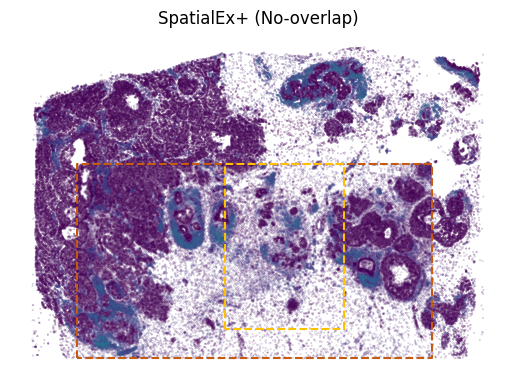

In [30]:
step = 9
gene_name = 'CD3E'
gene_idx = np.where(np.array(panelA) == gene_name)

x, y = spatial2[:, 0], spatial2[:, 1]
vmax = adata2[:, gene_name].X.max()

A2_inner = pd.read_csv('./output/ABLATION/Sliding_windows/Out/panelA2_indirect_Stride_'+str(step)+'.csv', index_col=0)
A2_out_s9 = pd.read_csv('./output/ABLATION/Sliding_windows/Out/panelA2_out_indirect_Stride_'+str(step)+'.csv', index_col=0)
pcc, pcc_reduce = Compute_metrics(adata2.X.copy(), A2_inner.values, metric='pcc', reduce='mean')

plt.scatter(x, y, c=A2_inner[gene_name].values, vmax=vmax, s=0.008)

inner_x_min, inner_x_max = x.min(), x.max()
inner_y_min, inner_y_max = y.min(), y.max()
y, x = coor_out2[:, 0], coor_out2[:, 1]
selection = (x<inner_x_min+50) + (x>inner_x_max) + (y<inner_y_min) + (y>inner_y_max-100)
plt.scatter(x[selection], y[selection], c=A2_out_s9[gene_name][selection], vmax=vmax, s=0.012)
plt.plot([inner_x_min, inner_x_min, inner_x_max, inner_x_max, inner_x_min], [inner_y_min, inner_y_max, inner_y_max, inner_y_min, inner_y_min],
        c='#C55A11', linestyle='--')

train_x_min, train_x_max = trainset2[:, 0].min(), trainset2[:, 0].max()
train_y_min, train_y_max = trainset2[:, 1].min(), trainset2[:, 1].max()
plt.plot([train_x_min, train_x_min, train_x_max, train_x_max, train_x_min], [train_y_min, train_y_max, train_y_max, train_y_min, train_y_min], 
         c='#FFC000', linestyle='--')

ax = plt.gca()
ax.set_aspect(1)
plt.axis('off')
str_pcc = str(np.round(pcc[np.where(adata2.var_names==gene_name)[0]], 2)[0])
plt.title('SpatialEx+ (No-overlap)', fontsize=12)
plt.show()